In [1]:
# add ASAP path to sys to locate the multiresolutionimageinterface
import sys
sys.path.append('C:\\Program Files\\ASAP 2.2\\bin')

import multiresolutionimageinterface as mir
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
from tqdm import tqdm_notebook
import pandas as pd

In [2]:
def sample_centers(tissue_mask, mask_downscale=16, sample_side=256, focus_width_percentage=0.25, padding_percentage=0.01):
    mask_width, mask_height = tissue_mask.shape[:2]
    side = sample_side / mask_downscale
    padding_width = mask_width*padding_percentage
    padding_height = mask_height*padding_percentage
    half_focus = int(sample_side*focus_width_percentage / mask_downscale)
    sample_centers = []
    
    for i in range(int(mask_width // side)):
        for j in range(int(mask_height // side)):
            for sub_shift in [0, 0.5]:
                x = int((i+sub_shift) * side)
                y = int((j+sub_shift) * side)
                min_x = int(max(0, x - half_focus))
                max_x = int(min(x + half_focus, mask_width - 1))
                min_y = int(max(0, y - half_focus))
                max_y = int(min(y + half_focus, mask_height - 1))
                
                if(min_x < padding_width or max_x > mask_width-padding_width): continue
                if(min_y < padding_height or max_y > mask_height-padding_height): continue
                
                if(tissue_mask[min_x:max_x, min_y:max_y].sum() > 0):
                    sample_centers.append(np.array([x, y]))
                    
    # undo mask downscale to coordinates
    sample_centers = np.array(sample_centers) * mask_downscale
    return sample_centers

In [3]:
def getTissueMask(tifPath):
    maskPath = tifPath.replace('.tif', '_tissue_mask_ds16.npy')
    if (not os.path.isfile(maskPath)): return None
    return np.load(maskPath)

In [4]:

reader = mir.MultiResolutionImageReader()

def getImage(tifPath):
    if (not os.path.isfile(tifPath)): return None
    return reader.open(tifPath)

def getAnnoMask(tifPath):
    maskPath = tifPath.replace('.tif', '_mask.tif')
    if (not os.path.isfile(maskPath)): return None
    return reader.open(maskPath)

In [5]:
def center2Bounds(center,ds=1, side=256):
    ''' Get an array of [x1,x2,y1,y2] from a center point in a set downsampling scale
    Args:
        center (int array of x,y): center point coordinate
        ds (int): downsampling scale
        side (int): size of the box side (default 256)
    '''
    assert center.shape[0] == 2, "Invalid center point shape. Got {0} but expected (2,)".format(center.shape)
    half_side = int((side / ds) // 2)
    return np.array([center[1]//ds-half_side,
                    center[1]//ds+half_side,
                    center[0]//ds-half_side,
                    center[0]//ds+half_side], dtype=np.int32)

In [6]:
def getPatchAndMasks(mr_image, mr_mask, tissue_mask,center, side=256):
    patch_bounds = center2Bounds(center)
    mask_bounds = center2Bounds(center, ds=16)
    
    channels = 3
    annoMask = np.zeros((side, side, channels), dtype=np.uint8)

    img = mr_image.getUCharPatch(int(patch_bounds[0]),
                                 int(patch_bounds[2]),
                                 side,
                                 side,
                                 0)
    
    tissueMask = tissue_mask[mask_bounds[2]:mask_bounds[3],mask_bounds[0]:mask_bounds[1]]
    if mr_mask is not None:
        annoMask = mr_mask.getUCharPatch(int(patch_bounds[0]),
                                     int(patch_bounds[2]),
                                     side,
                                     side,
                                     0)
    return img, tissueMask, np.array(annoMask)

In [7]:
import colorsys

def isTumor(mask_level_0):
    return (mask_level_0.max() > 0)

def tumorPercentage(mask_level_0):
    area = mask_level_0.shape[0] * mask_level_0.shape[1]
    tumorPixels = np.count_nonzero(mask_level_0)
    channels = 3
    return tumorPixels / (area * channels)

def tissuePercentage(tissueMask):
    area = tissueMask.shape[0] * tissueMask.shape[1]
    tissuePixels = np.count_nonzero(tissueMask)
    return tissuePixels / area

def colorMean(tissue):
    (b,g,r,a) = cv2.mean(tissue)
    return np.array([r,g,b])/255

def rgb2hsv(rgb):
    return colorsys.rgb_to_hsv(rgb[0], rgb[1], rgb[2])

In [8]:

imagePath = '../data/training/center_0/patient_004_node_4.tif'
tissue_mask = getTissueMask(imagePath)
patch_centers = sample_centers(tissue_mask)
print("Sliced WSI to {0} pathes.".format(len(patch_centers)))

mr_image = getImage(imagePath)
mr_mask = getAnnoMask(imagePath)

Sliced WSI to 60454 pathes.


In [9]:
print(patch_centers.shape)
patch_centers

(60454, 2)


array([[ 37504,  93568],
       [ 37632,  93440],
       [ 58752,  67968],
       ...,
       [123392,  51456],
       [123648,  50432],
       [123648,  50688]])

Text(0.5, 0.98, 'isTumor = True,\npercentage of tumor = 2.5 %\npercentage of tissue 100.0 %\nmeanHue 0.75\nmeanSaturation 0.2\nmeanValue 0.82')

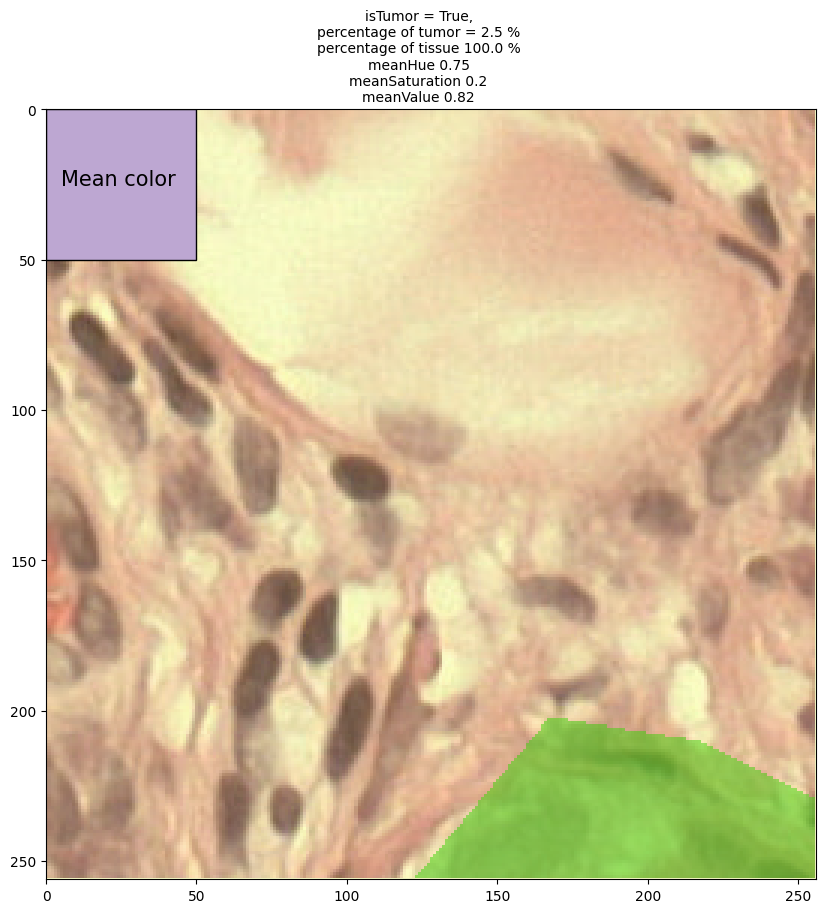

In [10]:
import matplotlib.patches as patches

random_index = 35564
#35564 has some tumor
#1000 on the outer edge
img,tissue,anno = getPatchAndMasks(mr_image, mr_mask, tissue_mask,patch_centers[random_index])
isTumor_attr = isTumor(anno)
tumorPrc_attr = tumorPercentage(anno)
tissuePrc_attr = tissuePercentage(tissue)
colorMean_attr = colorMean(img)
(mean_h, mean_s, mean_v) = rgb2hsv(colorMean_attr)

alpha = 0.5
# colorize
mask_color = anno * 200
# one channel to rgb
mask_color = np.concatenate([np.zeros(anno.shape),mask_color,np.zeros(anno.shape)],axis=2)

# create alpha channel to add to img and anno
alpha_c = np.ones((mask_color.shape[0], mask_color.shape[1], 1), dtype=np.uint8) * 255
mask_color = np.array(np.concatenate([mask_color, alpha_c], axis=2), dtype=np.uint8)
alpha_image = np.concatenate([img, alpha_c], axis=2)

for x in range(mask_color.shape[0]):
        for y in range(mask_color.shape[1]):
            mask_color[x, y, 3] = 255 if mask_color[x, y, 1] > 0 else 0

f, ax = plt.subplots(1,1,figsize = (10,10))
ax.imshow(alpha_image)
ax.imshow(mask_color,
          alpha=alpha,
          vmin=0,
          vmax=255)
ax.imshow(tissue,
          alpha=0.25,
          extent=(0,alpha_image.shape[0],alpha_image.shape[1],0),
          vmin=0,
          vmax=255,
          interpolation='bilinear',
          cmap='plasma')

# Create a Rectangle patch that shows the mean color
mean_color = patches.Rectangle((0,0),50,50,linewidth=1,edgecolor='black',facecolor=colorMean_attr)
ax.add_patch(mean_color)
ax.text(5, 20, 'Mean color',
        verticalalignment='top', horizontalalignment='left',
        color='black', fontsize=15)

f.suptitle('isTumor = {0},\npercentage of tumor = {1} %\npercentage of tissue {2} %\nmeanHue {3}\nmeanSaturation {4}\nmeanValue {5}'.format(isTumor_attr,
                                                                                                                                               int(tumorPrc_attr * 1000)/10,
                                                                                                                                               int(tissuePrc_attr * 1000)/10,
                                                                                                                                               int(mean_h * 100)/100,
                                                                                                                                               int(mean_s * 100)/100,
                                                                                                                                               int(mean_v * 100)/100 ),fontsize=10)

In [11]:
dirData = '../data/training/'
ImageFiles = []
# r=root, d=directories, f = files
for r, d, f in os.walk(dirData):
    for file in f:
        if '.tif' in file and 'mask' not in file:
            ImageFiles.append(r + '/' + file)

In [12]:
ImageFiles

['../data/training/center_0/patient_001_node_1.tif',
 '../data/training/center_0/patient_004_node_0.tif',
 '../data/training/center_0/patient_004_node_1.tif',
 '../data/training/center_0/patient_004_node_2.tif',
 '../data/training/center_0/patient_004_node_3.tif',
 '../data/training/center_0/patient_004_node_4.tif']

In [13]:
def CreateDF(tifPath, overrideExisting=False):
    
    # get only the name without dir or file suffix
    fileNamePart = tifPath.replace('.tif','').replace(dirData, "")
    df_path = '../data/training/dataframes/' + fileNamePart.split('/')[1] + '.csv'
    
    if (os.path.isfile(df_path) and overrideExisting == False):
        print('Info - Dataframe file of {0} already exists - skipping'.format(tifPath))
        return
    
    tissue_mask = getTissueMask(tifPath)
    patch_centers = sample_centers(tissue_mask)

    print("Sliced WSI {1} to {0} pathes.".format(len(patch_centers), tifPath))
    
    # modify the global images
    mr_image = getImage(tifPath)
    mr_mask = getAnnoMask(tifPath)
    
    df = pd.DataFrame(columns=['patchId',
                               'fileName',
                               'center',
                               'patient',
                               'node',
                               'centerX',
                               'centerY',
                               'isTumor',
                               'tumorPercentage',
                               'tissuePercentage',
                               'meanHue',
                               'meanSaturation',
                               'meanValue'])
    
    split = tifPath.split('/')
    cnt = int(split[2].strip('center_'))
    splitpatient = split[3].split('_')
    patient = int(splitpatient[1])
    node = int(splitpatient[3].strip('.tif'))
    
    for c in tqdm_notebook(patch_centers, 'Patches...'):
        img,tissue,anno = getPatchAndMasks(mr_image, mr_mask, tissue_mask, c)
        isTumor_attr = isTumor(anno)
        tumorPrc_attr = tumorPercentage(anno)
        tissuePrc_attr = tissuePercentage(tissue)
        colorMean_attr = colorMean(img)
        (mean_h, mean_s, mean_v) = rgb2hsv(colorMean_attr)
        
        df = df.append({'patchId': str(patient)+str(0)+str(c[0]).zfill(7)+str(c[1]).zfill(7),
                       'fileName': tifPath,
                       'center': cnt,
                      'patient': patient,
                      'node': node,
                      'centerX':c[0],
                      'centerY':c[1],
                      'isTumor':isTumor_attr,
                      'tumorPercentage': int(tumorPrc_attr * 1000)/10,
                      'tissuePercentage': int(tissuePrc_attr * 1000)/10,
                      'meanHue': int(mean_h * 100)/100,
                      'meanSaturation': int(mean_s * 100)/100,
                      'meanValue': int(mean_v * 100)/100}, ignore_index=True)
        
    df.to_csv(df_path)

In [14]:
for f in tqdm_notebook(ImageFiles, 'Creating dataframes...'):
    CreateDF(f)

C:\Users\songhow53\AppData\Local\Temp\ipykernel_2076\3206717726.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for f in tqdm_notebook(ImageFiles, 'Creating dataframes...'):


Creating dataframes...:   0%|          | 0/6 [00:00<?, ?it/s]

Sliced WSI ../data/training/center_0/patient_001_node_1.tif to 11764 pathes.


ValueError: invalid literal for int() with base 10: 'aining'

In [19]:
dftest = pd.read_csv('../data/training/dataframes/patient_001_node_1.csv')
dftest.head()

,Unnamed: 0,patchId,fileName,center,patient,node,centerX,centerY,isTumor,tumorPercentage,tissuePercentage,meanHue,meanSaturation,meanValue
0,0,1001207040038016,data/training/center_0/patient_001_node_1.tif,0,1,1,120704,38016,False,0.0,32.4,0.73,0.02,0.95
1,1,1001207040038272,data/training/center_0/patient_001_node_1.tif,0,1,1,120704,38272,False,0.0,42.1,0.71,0.02,0.96
2,2,1001209600037504,data/training/center_0/patient_001_node_1.tif,0,1,1,120960,37504,False,0.0,45.7,0.71,0.03,0.95
3,3,1001208320037632,data/training/center_0/patient_001_node_1.tif,0,1,1,120832,37632,False,0.0,26.5,0.70,0.01,0.97
4,4,1001209600037760,data/training/center_0/patient_001_node_1.tif,0,1,1,120960,37760,False,0.0,94.1,0.73,0.09,0.92
